# Data conversion, XGB and RANDOM FOREST!

In [51]:
# Gewoon alle code runnen, dan krijg je een file met alle predictions, je moet zorgen dat je de zorg21  en zorg 22  datasets hebt, en alle kwb files van 2018-2022
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

kwb_21 = pd.read_excel('./data/kwb-2021.xls')
kwb_22 = pd.read_excel('./data/kwb-2022.xls')
zorg21 = pd.read_csv('./data/85075NED_UntypedDataSet_15062023_115649.csv', delimiter=';')
zorg22 = pd.read_csv('./data/85335NED_UntypedDataSet_15062023_115413.csv', delimiter=';')

kwb_21['a_00_24'] = kwb_21['a_00_14'] + kwb_21['a_15_24']
kwb_22['a_00_24'] = kwb_22['a_00_14'] + kwb_22['a_15_24']

#  The zorg set has a column namen 'VormenVanJeugdzorg' that contains different types of jeugdzorg. We only want the total jeugdzorg so we are filtering the data where this column is equal to 'T001203'
zorg21 = zorg21[zorg21['VormenVanJeugdzorg'] == 'T001203']
zorg22 = zorg22[zorg22['VormenVanJeugdzorg'] == 'T001203']

zorg21['Wijken'] = zorg21['Wijken'].str.strip()  # Removing leading/trailing whitespaces
kwb_21['gwb_code_10'] = kwb_21['gwb_code_10'].str.strip()
zorg22['Wijken'] = zorg22['Wijken'].str.strip()
kwb_22['gwb_code_10'] = kwb_22['gwb_code_10'].str.strip()
kwb_21 = kwb_21[kwb_21['gwb_code_10'].str[:2] != 'BU']
kwb_22 = kwb_22[kwb_22['gwb_code_10'].str[:2] != 'BU']

# now adding this new column 'a_00_24' to the zorg datasets respectively by merging on the 'gwb_code_10' column for kwb and on the 'Wijken' column for zorg
zorg21 = zorg21.merge(kwb_21[['gwb_code_10', 'a_00_24']], left_on='Wijken', right_on='gwb_code_10', how='left')
zorg22 = zorg22.merge(kwb_22[['gwb_code_10', 'a_00_24']], left_on='Wijken', right_on='gwb_code_10', how='left')

# now we can calculate the percentage of youth till 24 in the total population by dividing the column 'a_00_24' by the column 'TotaalJongerenMetJeugdzorgInNatura_1' that is present in the zorg datasets
# we are adding a new column named 'p_jz_tn' to the zorg datasets 

zorg21['TotaalJongerenMetJeugdzorgInNatura_1'] = pd.to_numeric(zorg21['TotaalJongerenMetJeugdzorgInNatura_1'], errors='coerce')
zorg22['TotaalJongerenMetJeugdzorgInNatura_1'] = pd.to_numeric(zorg22['TotaalJongerenMetJeugdzorgInNatura_1'], errors='coerce')
zorg21['TotaalJongerenMetJeugdzorgInNatura_1'] = zorg21['TotaalJongerenMetJeugdzorgInNatura_1'].astype(float)
zorg22['TotaalJongerenMetJeugdzorgInNatura_1'] = zorg22['TotaalJongerenMetJeugdzorgInNatura_1'].astype(float)

zorg21['p_jz_tn'] = (zorg21['TotaalJongerenMetJeugdzorgInNatura_1'] / zorg21['a_00_24'])*100
zorg22['p_jz_tn'] = (zorg22['TotaalJongerenMetJeugdzorgInNatura_1'] / zorg22['a_00_24'])*100

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,ind_wbi,a_inw,a_man,a_vrouw,...,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,pst_mvp,pst_dekp,ste_mvs,ste_oad,a_00_24
0,NL00,0,Nederland,Nederland,Land,NL00,.,17475415,8686536,8788879,...,"0,7","10,7",4154338,3367109,787228,.,.,2,2024,4850952
1,GM0014,14,Groningen,Groningen,Gemeente,GM0014,.,233273,116177,117096,...,"0,7","9,6",19796,18560,1236,.,.,1,3312,77975
2,WK001400,1400,Centrum,Groningen,Wijk,WK001400,1,22735,11875,10860,...,"0,6","15,9",241,226,16,.,.,1,6353,10375
11,WK001401,1401,Oud-Zuid,Groningen,Wijk,WK001401,1,19695,9745,9950,...,"0,5","13,8",387,370,17,.,.,1,4047,7385
22,WK001402,1402,Oud-West,Groningen,Wijk,WK001402,1,14055,6905,7150,...,"0,6","15,7",118,112,6,.,.,1,5280,5435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17653,WK197915,197915,Buitengebied Zuid-Appingedam,Eemsdelta,Wijk,WK197915,3,105,60,50,...,"2,7","2,7",579,554,24,.,.,5,76,25
17657,WK197916,197916,Buitengebied Noord-Loppersum,Eemsdelta,Wijk,WK197916,2,3380,1670,1705,...,"1,9","1,6",2679,2647,32,.,.,5,289,790
17662,WK197917,197917,Buitengebied Noord-Stedum,Eemsdelta,Wijk,WK197917,2,1585,820,765,...,"1,1","0,9",2472,2459,13,.,.,5,97,400
17667,WK197918,197918,Buitengebied Noord-Middelstum,Eemsdelta,Wijk,WK197918,2,2570,1290,1275,...,"0,7","3,7",2554,2529,25,.,.,5,306,690


In [52]:
def append_str_to_columns(df, str):
    new_columns = []
    for column in df.columns:
        if column != "gwb_code_10":
            new_columns.append(column + '{}'.format(str))
        else:
            new_columns.append(column)
    df.columns = new_columns
    return df

# adding data about youth care to 2021 and 2022 datasets, because they did not exist before

zorg21 = zorg21[['Wijken', 'p_jz_tn']]
kwb_2021 = pd.read_excel('./data/kwb-2021.xls')
kwb_2021 = kwb_2021.applymap(lambda x: x.strip() if isinstance(x, str) else x)
kwb_2021 = kwb_2021[kwb_2021['gwb_code_10'].str[:2] != 'BU']
kwb_2021 = kwb_2021[[x for x in kwb_2021.columns if "p_jz_tn" not in x ]]
kwb_2021= kwb_2021.merge(zorg21, left_on='gwb_code_10', right_on='Wijken', how='left')

zorg22 = zorg22[['Wijken', 'p_jz_tn']]
kwb_2022 = pd.read_excel('./data/kwb-2022.xls')
kwb_2022 = kwb_2022.applymap(lambda x: x.strip() if isinstance(x, str) else x)
kwb_2022 = kwb_2022[kwb_2022['gwb_code_10'].str[:2] != 'BU']
kwb_2022 = kwb_2022[[x for x in kwb_2022.columns if "p_jz_tn" not in x ]]
kwb_2022= kwb_2022.merge(zorg22, left_on='gwb_code_10', right_on='Wijken', how='left')

In [53]:
dflist = ["./data/kwb-2018.xls", "./data/kwb-2019.xlsx","./data/kwb-2020.xls", kwb_2021, kwb_2022]
columnlist = ["gwb_code_10", "p_00_14",	"p_15_24",	"p_25_44",	"p_45_64",	"p_65_oo",	"p_ongeh",	"p_gehuwd",	"p_gesch",	"p_verwed",	"p_marok", "p_jz_tn", "p_antaru",	"p_suri","p_tur", "p_hh_z_k",	"p_hh_m_k", "bev_dich", "p_koopw",	"p_huurw", "g_ink_po",	"g_ink_pi",	"p_ink_li",	"p_ink_hi",	"p_n_act",	"p_hh_li",	"p_hh_hi",	"p_hh_lkk",	"p_hh_osm",	"a_soz_wb",	"a_soz_ao",	"a_soz_ww",	"a_soz_ow"]
stringlist = ["_2018", "_2019", "_2020", "_2021", "_2022"]

# getting all data and combining into dfs, also performing stripping, and turning useless values into nan

dfs = pd.DataFrame
for i in range(len(dflist)):
    if i == 0:
        print(dflist[i])
        df = pd.read_excel(dflist[i])
        df = df[df['gwb_code_10'].str[:2] != 'BU']
        df = df[df['gwb_code_10'].str[:2] != 'GM']
        df = df[df['gwb_code_10'].str[:2] != 'NL']
        df = df[[x for x in df.columns if x in columnlist]]
        df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
        df = df.replace([np.inf, -np.inf, np.nan, ".", "-"], np.nan)
        # comma to dot because the dutch system is stupid!
        df = df.applymap(lambda x: str(x.replace(',','.')) if isinstance(x, str) else x)
        df = df.apply(pd.to_numeric, errors='ignore')
        df = df.fillna(df.mean())
        df = append_str_to_columns(df, stringlist[i])
        dfs = df
    elif 0 < i < 3:
        print(dflist[i])
        df = pd.read_excel(dflist[i])
        df = df[df['gwb_code_10'].str[:2] != 'BU']
        df = df[df['gwb_code_10'].str[:2] != 'GM']
        df = df[df['gwb_code_10'].str[:2] != 'NL']
        df = df[[x for x in df.columns if x in columnlist]]
        df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
        df = df.replace([np.inf, -np.inf, np.nan, ".", "-"], np.nan)
        df = df.applymap(lambda x: str(x.replace(',','.')) if isinstance(x, str) else x)
        df = append_str_to_columns(df, stringlist[i])
        dfs = pd.merge(dfs, df, on='gwb_code_10', how='outer')
    else:
        df = dflist[i]
        df = df[df['gwb_code_10'].str[:2] != 'BU']
        df = df[df['gwb_code_10'].str[:2] != 'GM']
        df = df[df['gwb_code_10'].str[:2] != 'NL']
        df = df[[x for x in df.columns if x in columnlist]]
        df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
        df = df.replace([np.inf, -np.inf, np.nan, ".", "-"], np.nan)
        df = df.applymap(lambda x: str(x.replace(',','.')) if isinstance(x, str) else x)
        df = append_str_to_columns(df, stringlist[i])
        dfs = pd.merge(dfs, df, on='gwb_code_10', how='outer')

./data/kwb-2018.xls


C:\Users\stanf\AppData\Local\Temp/ipykernel_16796/1406392611.py:21: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



./data/kwb-2019.xlsx
./data/kwb-2020.xls


In [54]:
# handling missing data, and sorting columns for forward fill

cols = sorted(dfs.columns)
cols.remove("gwb_code_10")
cols = ["gwb_code_10"] + cols
dfs = dfs[cols]

for x in dfs.columns:
    if "2018" in x:
        dfs[x] = dfs[x].fillna(dfs[x].mean())

dfs = dfs.ffill(axis='columns')
dfs = dfs.apply(pd.to_numeric, errors='ignore')

display(dfs)

,gwb_code_10,a_soz_ao_2018,a_soz_ao_2019,a_soz_ao_2020,a_soz_ao_2021,a_soz_ao_2022,a_soz_ow_2018,a_soz_ow_2019,a_soz_ow_2020,a_soz_ow_2021,...,p_jz_tn_2018,p_jz_tn_2019,p_jz_tn_2020,p_jz_tn_2021,p_jz_tn_2022,p_koopw_2018,p_koopw_2019,p_koopw_2020,p_koopw_2021,p_koopw_2022
0,WK000300,710.000000,730.000000,710.000000,710.000000,710.000000,2670.000000,2670.000000,2750.000000,2750.000000,...,9.900000,11.500000,10.200000,10.200000,10.200000,49.000000,48.000000,48.000000,48.000000,48.0
1,WK000500,580.000000,580.000000,580.000000,580.000000,580.000000,2080.000000,2080.000000,2080.000000,2080.000000,...,9.900000,9.900000,9.900000,9.900000,9.900000,69.000000,69.000000,69.000000,69.000000,69.0
2,WK000900,150.000000,150.000000,150.000000,150.000000,150.000000,1170.000000,1170.000000,1170.000000,1170.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,76.000000,76.000000,76.000000,76.000000,76.0
3,WK000901,50.000000,50.000000,50.000000,50.000000,50.000000,190.000000,190.000000,190.000000,190.000000,...,9.600000,9.600000,9.600000,9.600000,9.600000,78.000000,78.000000,78.000000,78.000000,78.0
4,WK001000,870.000000,870.000000,870.000000,870.000000,870.000000,4230.000000,4230.000000,4230.000000,4230.000000,...,10.600000,10.600000,10.600000,10.600000,10.600000,55.000000,55.000000,55.000000,55.000000,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705,WK199102,244.602329,244.602329,244.602329,244.602329,244.602329,1011.044925,1011.044925,1011.044925,1011.044925,...,8.408712,8.408712,8.408712,8.408712,5.789474,66.486352,66.486352,66.486352,66.486352,73.0
3706,WK199103,244.602329,244.602329,244.602329,244.602329,244.602329,1011.044925,1011.044925,1011.044925,1011.044925,...,8.408712,8.408712,8.408712,8.408712,8.333333,66.486352,66.486352,66.486352,66.486352,76.0
3707,WK199104,244.602329,244.602329,244.602329,244.602329,244.602329,1011.044925,1011.044925,1011.044925,1011.044925,...,8.408712,8.408712,8.408712,8.408712,5.974026,66.486352,66.486352,66.486352,66.486352,74.0
3708,WK199105,244.602329,244.602329,244.602329,244.602329,244.602329,1011.044925,1011.044925,1011.044925,1011.044925,...,8.408712,8.408712,8.408712,8.408712,9.090909,66.486352,66.486352,66.486352,66.486352,74.0


In [55]:
# percentages to log
# dfs[[x for x in dfs.columns if "p_" in x]] = np.log2(dfs[[x for x in dfs.columns if "p_" in x]].div(100))
# dfs = dfs.replace([np.inf, -np.inf, np.nan, ".", "-"], np.nan)
# dfs[[x for x in dfs.columns if "p_" in x]] = dfs[[x for x in dfs.columns if "p_" in x]].fillna(-5000)
# display(dfs)

In [56]:
# Extract features and target variable
target = dfs['p_jz_tn_2022']
features = dfs[[x for x in dfs.columns if "2022" not in x]]
features = features[[x for x in features.columns if "gwb_code_10" not in x]]
pred_set = dfs[[x for x in dfs.columns if "2018" not in x]]
pred_set = pred_set[[x for x in pred_set.columns if "gwb_code_10" not in x]]
pred_set.columns = features.columns

In [57]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 2.585862872240392
R^2 Score: 0.6985671630494916


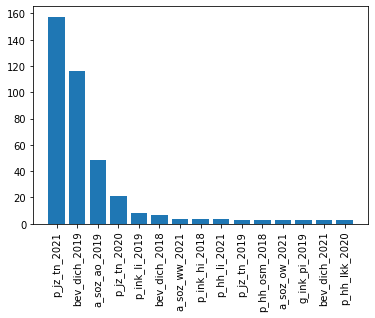

In [58]:
import matplotlib.pyplot as plt
feature_importance = sorted(xgb_model.get_booster().get_score(importance_type="gain").items(), key=lambda x:x[1], reverse=True)

features_imp = list(zip(*feature_importance))[0]
importances = list(zip(*feature_importance))[1]

plt.bar(range(len(feature_importance[:15])), importances[:15], tick_label=features_imp[:15])
plt.xticks(rotation = 90)
plt.show()

In [59]:
prediction_xgb = xgb_model.predict(pred_set)
dfs["prediction_xgb"] = prediction_xgb

In [60]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the regressor
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate the root mean squared error (RMSE) of the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 1.5831535535834413


In [61]:
prediction_rf = rf_regressor.predict(pred_set)
dfs["prediction_rf"] = prediction_rf

In [62]:
display(dfs)
dfs.to_csv("data_predictions.csv")

,gwb_code_10,a_soz_ao_2018,a_soz_ao_2019,a_soz_ao_2020,a_soz_ao_2021,a_soz_ao_2022,a_soz_ow_2018,a_soz_ow_2019,a_soz_ow_2020,a_soz_ow_2021,...,p_jz_tn_2020,p_jz_tn_2021,p_jz_tn_2022,p_koopw_2018,p_koopw_2019,p_koopw_2020,p_koopw_2021,p_koopw_2022,prediction_xgb,prediction_rf
0,WK000300,710.000000,730.000000,710.000000,710.000000,710.000000,2670.000000,2670.000000,2750.000000,2750.000000,...,10.200000,10.200000,10.200000,49.000000,48.000000,48.000000,48.000000,48.0,9.778097,10.011940
1,WK000500,580.000000,580.000000,580.000000,580.000000,580.000000,2080.000000,2080.000000,2080.000000,2080.000000,...,9.900000,9.900000,9.900000,69.000000,69.000000,69.000000,69.000000,69.0,9.806551,9.889182
2,WK000900,150.000000,150.000000,150.000000,150.000000,150.000000,1170.000000,1170.000000,1170.000000,1170.000000,...,9.000000,9.000000,9.000000,76.000000,76.000000,76.000000,76.000000,76.0,8.954511,8.981468
3,WK000901,50.000000,50.000000,50.000000,50.000000,50.000000,190.000000,190.000000,190.000000,190.000000,...,9.600000,9.600000,9.600000,78.000000,78.000000,78.000000,78.000000,78.0,9.446232,9.677288
4,WK001000,870.000000,870.000000,870.000000,870.000000,870.000000,4230.000000,4230.000000,4230.000000,4230.000000,...,10.600000,10.600000,10.600000,55.000000,55.000000,55.000000,55.000000,55.0,10.665432,10.447089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705,WK199102,244.602329,244.602329,244.602329,244.602329,244.602329,1011.044925,1011.044925,1011.044925,1011.044925,...,8.408712,8.408712,5.789474,66.486352,66.486352,66.486352,66.486352,73.0,6.563620,6.389380
3706,WK199103,244.602329,244.602329,244.602329,244.602329,244.602329,1011.044925,1011.044925,1011.044925,1011.044925,...,8.408712,8.408712,8.333333,66.486352,66.486352,66.486352,66.486352,76.0,8.352372,8.310010
3707,WK199104,244.602329,244.602329,244.602329,244.602329,244.602329,1011.044925,1011.044925,1011.044925,1011.044925,...,8.408712,8.408712,5.974026,66.486352,66.486352,66.486352,66.486352,74.0,6.962126,6.651279
3708,WK199105,244.602329,244.602329,244.602329,244.602329,244.602329,1011.044925,1011.044925,1011.044925,1011.044925,...,8.408712,8.408712,9.090909,66.486352,66.486352,66.486352,66.486352,74.0,8.822793,9.018450


# Visualising

This is not needed for the prediction, merely some visualisations for checking.

In [63]:
df = pd.read_excel("./data/kwb-2018.xls")
df = df[['gwb_code_10', 'gm_naam', 'regio']]
dfs = pd.merge(dfs, df, on='gwb_code_10', how='left')

In [64]:
ts_total, ts_2018, ts_2019, ts_2020, ts_2021, ts_2022, ts_2023 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
dflist = [ts_2018, ts_2019, ts_2020, ts_2021, ts_2022, ts_2023]

form = "prediction_xgb"
for df in range(len(dflist)):
    if df != 5:
        dflist[df] = dfs[['gwb_code_10', 'gm_naam', 'regio'] + [x for x in dfs.columns if "{}".format(2018+df) in x]]
        dflist[df].columns = pd.Index(map(lambda x : str(x)[:-5], dflist[df].columns[3:])).insert(0, "gwb_code_10").insert(1, 'gm_naam').insert(2, 'regio')
        dflist[df].loc[:, 'year'] = pd.to_datetime('{}'.format(2018+df))
        ts_total = pd.concat([ts_total, dflist[df]])
    elif form == "prediction_rf":
        dflist[df] = dfs[['gwb_code_10', 'gm_naam', 'regio', "prediction_rf"] + [x for x in dfs.columns if "2022" in x]]
        dflist[df].columns = pd.Index(map(lambda x : str(x)[:-5], dflist[df].columns[4:])).insert(0, "gwb_code_10").insert(1, 'gm_naam').insert(2, 'regio').insert(3, "prediction_rf")
        dflist[df] = dflist[df].drop("p_jz_tn", axis=1)
        dflist[df] = dflist[df].rename(columns={"prediction_rf" : "p_jz_tn"})
        dflist[df].loc[:, 'year'] = pd.to_datetime('{}'.format(2018+df))
        ts_total = pd.concat([ts_total, dflist[df]])
    elif form == "prediction_xgb":
        dflist[df] = dfs[['gwb_code_10', 'gm_naam', 'regio', "prediction_xgb"] + [x for x in dfs.columns if "2022" in x]]
        dflist[df].columns = pd.Index(map(lambda x : str(x)[:-5], dflist[df].columns[4:])).insert(0, "gwb_code_10").insert(1, 'gm_naam').insert(2, 'regio').insert(3, "prediction_xgb")
        dflist[df] = dflist[df].drop("p_jz_tn", axis=1)
        dflist[df] = dflist[df].rename(columns={"prediction_xgb" : "p_jz_tn"})
        dflist[df].loc[:, 'year'] = pd.to_datetime('{}'.format(2018+df))
        ts_total = pd.concat([ts_total, dflist[df]])
        

# ts_total[[x for x in ts_total.columns if "p_" in x]] = np.exp(ts_total[[x for x in ts_total.columns if "p_" in x]]).multiply(100)

C:\Users\stanf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
ts_amsterdam = ts_total[ts_total.gm_naam == "Haarlem"]

In [70]:
import plotly.io as pio
pio.renderers.default = "vscode"
import plotly.express as px
fig = px.line(ts_amsterdam, x="year", y="p_jz_tn", color="regio")
fig.show()